## 1 ML - RFM을 통한 고객 세분화

### 1. 전처리 및 EDA

In [7]:
import pandas as pd

In [194]:
data = pd.read_csv('UK.csv')

In [195]:
data.dropna(inplace = True)

In [196]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)

In [197]:
data['sale_amount'] = data['Quantity'] * data['UnitPrice']
data['CustomerID'] = data['CustomerID'].astype(int)
inv = data.groupby('CustomerID').CustomerID.size().reset_index(name = 'InvoiceNo')
cust_df = data.groupby('CustomerID').agg({'InvoiceDate' : 'max', 'sale_amount' : 'sum'}).reset_index()

### 2. Feature Engineering 및 파생변수 생성

In [198]:
data['Month'] = data.InvoiceDate.dt.month
data['Hour'] = data.InvoiceDate.dt.hour

In [199]:
time_df = data.groupby('CustomerID').agg({'Hour' : 'mean', 'Month' : 'mean'}).reset_index()

In [200]:
cust_df = pd.concat([inv, cust_df.iloc[:, 1:], time_df.iloc[:, 1:]], axis = 1, ignore_index = True)
cust_df.columns = ['CustomerID', 'Frequency', 'Recency', 'Monetary', 'mean_hour', 'mean_month']
cust_df.set_index('CustomerID', inplace = True)

In [208]:
cust_df.head()

,Frequency,Recency,Monetary,mean_hour,mean_month
CustomerID,,,,,
12346,2,326,0.00,10.000000,1.000000
12747,103,3,4196.01,12.029126,7.718447
12748,4642,1,29072.10,13.481043,9.301163
12749,231,4,3868.20,12.090909,8.389610
12820,59,4,942.34,12.745763,8.491525


In [144]:
import datetime as dt

In [202]:
cust_df.Recency = dt.datetime(2011, 12, 10) - cust_df.Recency

In [203]:
cust_df.Recency = cust_df.Recency.apply(lambda x : x.days + 1)

In [209]:
cust_df.head()

,Frequency,Recency,Monetary,mean_hour,mean_month
CustomerID,,,,,
12346,2,326,0.00,10.000000,1.000000
12747,103,3,4196.01,12.029126,7.718447
12748,4642,1,29072.10,13.481043,9.301163
12749,231,4,3868.20,12.090909,8.389610
12820,59,4,942.34,12.745763,8.491525


In [214]:
from sklearn.preprocessing import MinMaxScaler

In [215]:
scaler = MinMaxScaler()

In [216]:
scaled_df = scaler.fit_transform(cust_df)

In [217]:
scaled_df = pd.DataFrame(scaled_df, columns = cust_df.columns, index = cust_df.index)

In [218]:
scaled_df.head()

,Frequency,Recency,Monetary,mean_hour,mean_month
CustomerID,,,,,
12346,0.000125,0.871314,0.016445,0.172932,0.000000
12747,0.012779,0.005362,0.032539,0.340755,0.610768
12748,0.581433,0.000000,0.127949,0.460838,0.754651
12749,0.028815,0.008043,0.031281,0.345865,0.671783
12820,0.007266,0.008043,0.020059,0.400025,0.681048


### 3. 군집 분석 및 적절한 집단 갯수 설정

In [219]:
from sklearn.cluster import KMeans

In [223]:
cls_n = range(1, 11)
inertia_list = []

In [224]:
for k in cls_n :
    model = KMeans(n_clusters = k, random_state = 605, max_iter = 1000).fit(scaled_df)
    inertia_list.append(model.inertia_)

In [212]:
import matplotlib.pyplot as plt
%matplotlib inline

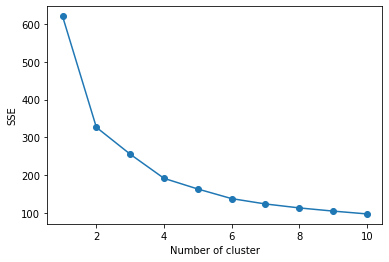

In [225]:
plt.plot(cls_n, inertia_list, marker = 'o')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

군집개수 4로 설정

### 4. 군집별 의미 파악 + 군집별로 월 기준으로 rfm 히트맵 그리기

In [227]:
model = KMeans(4, random_state = 605, max_iter = 1000).fit(scaled_df)
cust_df['cls'] = model.labels_

In [231]:
cust_df.reset_index().iloc[:,[0,-1]]

,CustomerID,cls
0,12346,0
1,12747,1
2,12748,2
3,12749,2
4,12820,2
...,...,...
3945,18280,0
3946,18281,0
3947,18282,2
3948,18283,1


### 5. 군집별 마케팅 인사이트 도출

## 2 시계열 

- sales값 예측

In [112]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [118]:
data.set_index('InvoiceDate', inplace = True)

In [119]:
ts_df = data.iloc[:, 1:].resample('D').sum()

In [120]:
ts_df

,Quantity,UnitPrice,sale_amount
InvoiceDate,,,
2010-12-01,21167,5764.05,42030.85
2010-12-02,20705,6539.18,45622.08
2010-12-03,7357,2957.19,17512.44
2010-12-04,0,0.00,0.00
2010-12-05,13603,7102.72,25458.85
...,...,...,...
2011-12-05,36600,11341.01,53598.46
2011-12-06,24885,5633.66,39738.14
2011-12-07,28993,4245.88,48943.63


### 1. 전처리 수행 및 EDA

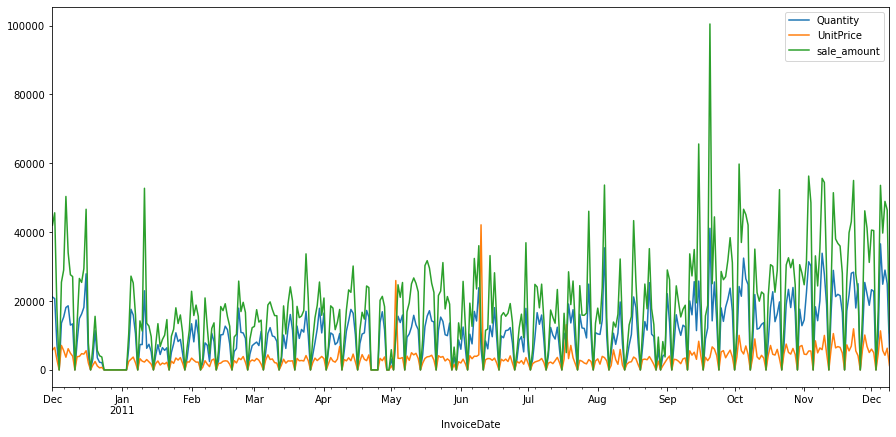

In [240]:
plt.rcParams['figure.figsize'] = (15 ,7)
ts_df.plot()
plt.show()

In [235]:
from statsmodels.tsa.seasonal import seasonal_decompose

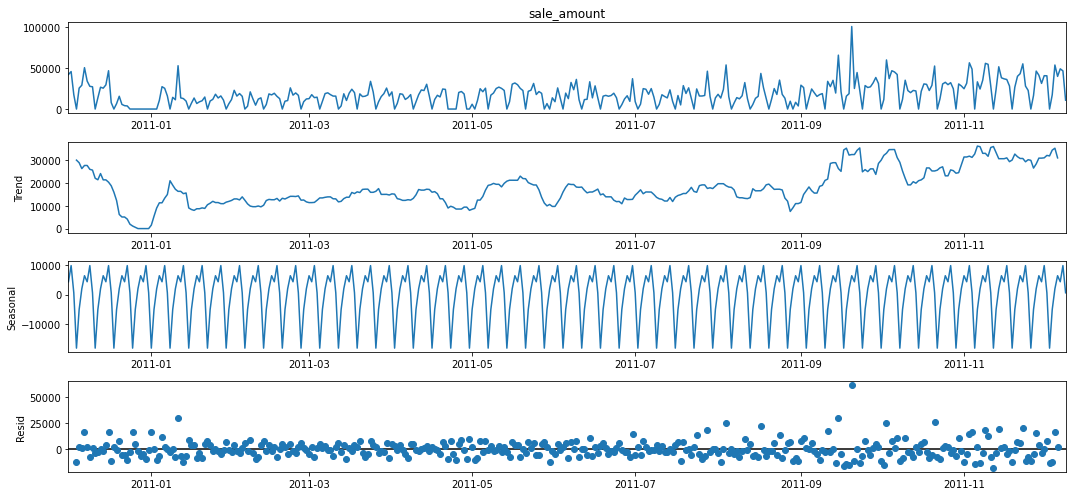

In [275]:
d = seasonal_decompose(ts_df.sale_amount)
d.plot()
plt.show()

In [278]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

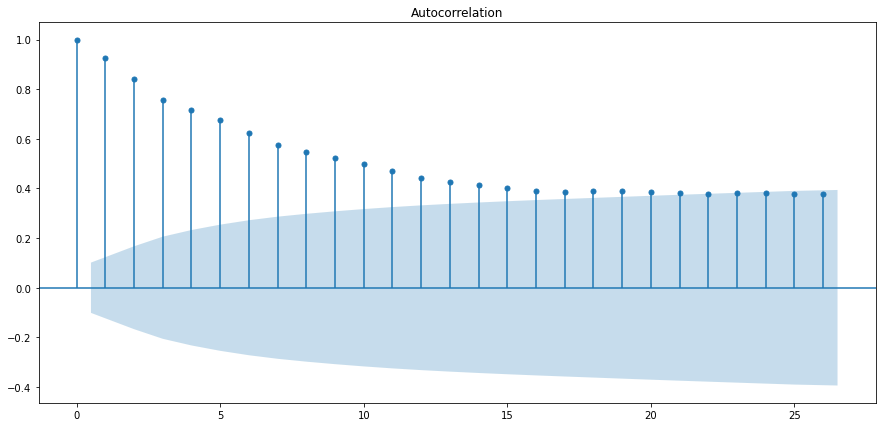

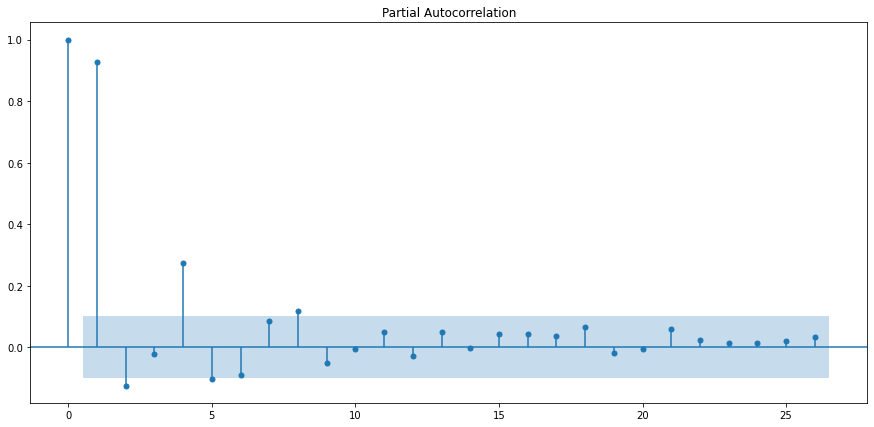

In [282]:
plot_acf(d.trend.fillna(0))
plot_pacf(d.trend.fillna(0))
plt.show()

### 2. 정상성 검정

In [236]:
from statsmodels.tsa.stattools import kpss

In [237]:
statistic, p_value, n_lags, critial_values = kpss(ts_df.sale_amount)

print("KPSS Statistic : {}".format(statistic))
print("P-value : {}".format(p_value))
print("num_lags : {}".format(n_lags))
print("Critial_values : {}".format(critial_values))

KPSS Statistic : 1.2227906140172484
P-value : 0.01
num_lags : 17
Critial_values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [239]:
statistic, p_value, n_lags, critial_values = kpss(ts_df.sale_amount.diff(7).dropna())

print("KPSS Statistic : {}".format(statistic))
print("P-value : {}".format(p_value))
print("num_lags : {}".format(n_lags))
print("Critial_values : {}".format(critial_values))

KPSS Statistic : 0.16772120300207138
P-value : 0.1
num_lags : 17
Critial_values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [241]:
from statsmodels.tsa.stattools import adfuller

In [246]:
y = ts_df['sale_amount']
y1dif = ts_df['sale_amount'].diff(periods = 7).dropna()

result = adfuller(y)
print("원 데이터의 ADF 값 : {}".format(result[0]))
print('원 데이터의 P-value : {}\n'.format(result[1]))

result1 = adfuller(y1dif, autolag = None)
print("1차 차분 데이터의 ADF 값 : {}".format(result1[0]))
print('1차 차분 데이터의 P-value : {}'.format(result1[1]))

원 데이터의 ADF 값 : -2.0385165255824247
원 데이터의 P-value : 0.26994435620382634

1차 차분 데이터의 ADF 값 : -5.587557930401772
1차 차분 데이터의 P-value : 1.3520773655531406e-06


d = 1, D = 1로 파라미터를 결정한다.

### 3. sales 데이터만을 이용하여 시계열 분석 후 사후 분석

In [253]:
y_train = ts_df.sale_amount.iloc[:344]
y_test = ts_df.sale_amount.iloc[344:]

In [261]:
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_squared_error
from itertools import product, combinations
from tqdm import tqdm
from statsmodels.tsa.api import SARIMAX
p, q = range(0,3), range(0,3)
d = range(2)
P, Q = range(0,3), range(0,3)
D = range(2)
m = 7
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2], m) for candi in list(product(P, D, Q))]
## SARIMAX
AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
    for seasonal_params in seasonal_pdq:
        try:
            result = SARIMAX(y_train, trend = 'c', 
                                   order = trend_param, seasonal_order = seasonal_params, exog = None).fit()
            print('Fit SARIMAX: trend_order={} seasonal_order={} AIC={}, BIC={}'.format(trend_param, seasonal_params, result.aic, result.bic, end='\r'))
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue
## Parameter Selection
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0], SARIMAX_order[AIC.index(min(AIC))][1]))

  0%|          | 0/18 [00:00<?, ?it/s]

Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(0, 0, 0, 7) AIC=7524.598124271766, BIC=7532.279407586513
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(0, 0, 1, 7) AIC=7455.656215742243, BIC=7467.1781407143635
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(0, 0, 2, 7) AIC=7432.427373853277, BIC=7447.78994048277
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(0, 1, 0, 7) AIC=7307.144623175447, BIC=7314.784789036152
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(0, 1, 1, 7) AIC=7167.684508820186, BIC=7179.144757611243
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(0, 1, 2, 7) AIC=7159.084827095266, BIC=7174.365158816675
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(1, 0, 0, 7) AIC=7485.390554616285, BIC=7496.912479588405
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(1, 0, 1, 7) AIC=7452.33752394444, BIC=7467.700090573934


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(1, 0, 2, 7) AIC=7432.97694640551, BIC=7452.180154692377
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(1, 1, 0, 7) AIC=7256.06864845559, BIC=7267.528897246647


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(1, 1, 1, 7) AIC=7159.027941968224, BIC=7174.308273689633
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(1, 1, 2, 7) AIC=7191.171482954349, BIC=7210.2718976061105
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(2, 0, 0, 7) AIC=7487.388162483259, BIC=7502.750729112753
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(2, 0, 1, 7) AIC=7422.9686773941885, BIC=7442.171885681056
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(2, 0, 2, 7) AIC=7423.733116325104, BIC=7446.7769662693445
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(2, 1, 0, 7) AIC=7241.12916816836, BIC=7256.409499889769
Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(2, 1, 1, 7) AIC=7191.074764618632, BIC=7210.1751792703935


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  6%|▌         | 1/18 [00:07<02:04,  7.30s/it]

Fit SARIMAX: trend_order=(0, 0, 0) seasonal_order=(2, 1, 2, 7) AIC=7183.486300768729, BIC=7206.406798350843
Fit SARIMAX: trend_order=(0, 0, 1) seasonal_order=(0, 0, 0, 7) AIC=7492.512157950311, BIC=7504.0340829224315
Fit SARIMAX: trend_order=(0, 0, 1) seasonal_order=(0, 0, 1, 7) AIC=7430.942110942924, BIC=7446.304677572418
Fit SARIMAX: trend_order=(0, 0, 1) seasonal_order=(0, 0, 2, 7) AIC=7413.227337111184, BIC=7432.430545398051
Fit SARIMAX: trend_order=(0, 0, 1) seasonal_order=(0, 1, 0, 7) AIC=7299.662213075506, BIC=7311.122461866563
Fit SARIMAX: trend_order=(0, 0, 1) seasonal_order=(0, 1, 1, 7) AIC=7189.31474879822, BIC=7204.595080519629
Fit SARIMAX: trend_order=(0, 0, 1) seasonal_order=(0, 1, 2, 7) AIC=7180.020052353122, BIC=7199.120467004884
Fit SARIMAX: trend_order=(0, 0, 1) seasonal_order=(1, 0, 0, 7) AIC=7438.690885231526, BIC=7454.05345186102
Fit SARIMAX: trend_order=(0, 0, 1) seasonal_order=(1, 0, 1, 7) AIC=7423.461193249159, BIC=7442.664401536026
Fit SARIMAX: trend_order=(0, 

/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 11%|█         | 2/18 [00:14<01:52,  7.06s/it]

Fit SARIMAX: trend_order=(0, 0, 1) seasonal_order=(2, 1, 2, 7) AIC=7176.696757292745, BIC=7203.437337805211
Fit SARIMAX: trend_order=(0, 0, 2) seasonal_order=(0, 0, 0, 7) AIC=7490.828659290083, BIC=7506.191225919577
Fit SARIMAX: trend_order=(0, 0, 2) seasonal_order=(0, 0, 1, 7) AIC=7430.372068965664, BIC=7449.575277252531
Fit SARIMAX: trend_order=(0, 0, 2) seasonal_order=(0, 0, 2, 7) AIC=7412.125049418535, BIC=7435.168899362776
Fit SARIMAX: trend_order=(0, 0, 2) seasonal_order=(0, 1, 0, 7) AIC=7300.92900711019, BIC=7316.209338831599
Fit SARIMAX: trend_order=(0, 0, 2) seasonal_order=(0, 1, 1, 7) AIC=7173.370659038143, BIC=7192.471073689904
Fit SARIMAX: trend_order=(0, 0, 2) seasonal_order=(0, 1, 2, 7) AIC=7182.8862837541765, BIC=7205.80678133629
Fit SARIMAX: trend_order=(0, 0, 2) seasonal_order=(1, 0, 0, 7) AIC=7435.439569720542, BIC=7454.642778007409
Fit SARIMAX: trend_order=(0, 0, 2) seasonal_order=(1, 0, 1, 7) AIC=7423.317517172018, BIC=7446.361367116258
Fit SARIMAX: trend_order=(0, 

 17%|█▋        | 3/18 [00:22<01:51,  7.43s/it]

Fit SARIMAX: trend_order=(0, 0, 2) seasonal_order=(2, 1, 2, 7) AIC=7185.274083753644, BIC=7215.834747196463
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 0, 0, 7) AIC=7599.992418909302, BIC=7607.667879803634
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 0, 1, 7) AIC=7550.086889924893, BIC=7561.600081266391
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 0, 2, 7) AIC=7536.796533288221, BIC=7552.147455076885
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 1, 0, 7) AIC=7448.678677374404, BIC=7456.312899694331
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 1, 1, 7) AIC=7305.696159885033, BIC=7317.147493364922
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 1, 2, 7) AIC=7333.5361669859785, BIC=7348.804611625831
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(1, 0, 0, 7) AIC=7528.434118806232, BIC=7539.94731014773


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(1, 0, 1, 7) AIC=7471.044670095186, BIC=7486.39559188385
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(1, 0, 2, 7) AIC=7493.551668440001, BIC=7512.740320675831
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(1, 1, 0, 7) AIC=7394.6355371134105, BIC=7406.0868705933
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(1, 1, 1, 7) AIC=7300.019318557693, BIC=7315.287763197545
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(1, 1, 2, 7) AIC=7335.525241997873, BIC=7354.610797797689
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(2, 0, 0, 7) AIC=7520.340901379695, BIC=7535.691823168359
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(2, 0, 1, 7) AIC=7493.515359658162, BIC=7512.704011893992
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(2, 0, 2, 7) AIC=7497.537370899699, BIC=7520.563753582695
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(2, 1, 0, 7) AIC=7377.129784179697, BIC=7392.398228819549
Fit SARIMAX: trend_order=(0, 1

 22%|██▏       | 4/18 [00:27<01:34,  6.75s/it]

Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(2, 1, 2, 7) AIC=7336.609746078054, BIC=7359.512413037833
Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 0, 0, 7) AIC=7464.214340629724, BIC=7475.727531971222
Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 0, 1, 7) AIC=7429.411162772395, BIC=7444.762084561059
Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 0, 2, 7) AIC=7414.484623585138, BIC=7433.673275820968
Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 1, 0, 7) AIC=7316.295776164994, BIC=7327.7471096448835


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 1, 1, 7) AIC=7147.435762989269, BIC=7162.704207629122


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 1, 2, 7) AIC=7147.529367032076, BIC=7166.614922831892


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(1, 0, 0, 7) AIC=7375.914315630689, BIC=7391.265237419353


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(1, 0, 1, 7) AIC=7349.983530654636, BIC=7369.172182890466


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(1, 0, 2, 7) AIC=7366.667949885981, BIC=7389.694332568977
Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(1, 1, 0, 7) AIC=7253.994831752876, BIC=7269.263276392729


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(1, 1, 1, 7) AIC=7152.023424458199, BIC=7171.1089802580145


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(1, 1, 2, 7) AIC=7194.8550378647315, BIC=7217.75770482451
Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(2, 0, 0, 7) AIC=7390.979755093914, BIC=7410.168407329744


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(2, 0, 1, 7) AIC=7367.167832100717, BIC=7390.194214783713
Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(2, 0, 2, 7) AIC=7381.059563508188, BIC=7407.92367663835
Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(2, 1, 0, 7) AIC=7239.312995187096, BIC=7258.398550986912


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(2, 1, 1, 7) AIC=7194.961588608717, BIC=7217.8642555684955


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 28%|██▊       | 5/18 [00:38<01:48,  8.32s/it]

Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(2, 1, 2, 7) AIC=7196.650427066119, BIC=7223.370205185862
Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 0, 0, 7) AIC=7448.98400637577, BIC=7464.334928164434
Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 0, 1, 7) AIC=7396.305538443037, BIC=7415.494190678867
Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 0, 2, 7) AIC=7381.270113968335, BIC=7404.296496651331
Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 1, 0, 7) AIC=7300.385582048082, BIC=7315.654026687935
Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 1, 1, 7) AIC=7189.0193431164535, BIC=7208.104898916269
Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 1, 2, 7) AIC=7190.191659314072, BIC=7213.094326273851
Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(1, 0, 0, 7) AIC=7372.687834479109, BIC=7391.876486714939


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(1, 0, 1, 7) AIC=7326.441900896366, BIC=7349.468283579362


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(1, 0, 2, 7) AIC=7334.68920805459, BIC=7361.553321184752
Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(1, 1, 0, 7) AIC=7254.186883570996, BIC=7273.272439370811


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(1, 1, 1, 7) AIC=7170.514091413488, BIC=7193.416758373267
Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(1, 1, 2, 7) AIC=7190.534862015109, BIC=7217.254640134852
Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(2, 0, 0, 7) AIC=7365.01666494422, BIC=7388.043047627216


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(2, 0, 1, 7) AIC=7334.710745576018, BIC=7361.57485870618


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(2, 0, 2, 7) AIC=7337.656696657533, BIC=7368.358540234861
Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(2, 1, 0, 7) AIC=7238.823046872627, BIC=7261.725713832406
Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(2, 1, 1, 7) AIC=7191.955916225221, BIC=7218.675694344964


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 33%|███▎      | 6/18 [00:52<02:01, 10.13s/it]

Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(2, 1, 2, 7) AIC=7193.268953323922, BIC=7223.805842603628
Fit SARIMAX: trend_order=(1, 0, 0) seasonal_order=(0, 0, 0, 7) AIC=7487.899096716335, BIC=7499.421021688456
Fit SARIMAX: trend_order=(1, 0, 0) seasonal_order=(0, 0, 1, 7) AIC=7426.315108577659, BIC=7441.677675207153
Fit SARIMAX: trend_order=(1, 0, 0) seasonal_order=(0, 0, 2, 7) AIC=7407.891695882863, BIC=7427.09490416973
Fit SARIMAX: trend_order=(1, 0, 0) seasonal_order=(0, 1, 0, 7) AIC=7299.013750620619, BIC=7310.473999411676
Fit SARIMAX: trend_order=(1, 0, 0) seasonal_order=(0, 1, 1, 7) AIC=7185.905477003297, BIC=7201.1858087247065
Fit SARIMAX: trend_order=(1, 0, 0) seasonal_order=(0, 1, 2, 7) AIC=7183.211877935184, BIC=7202.312292586946
Fit SARIMAX: trend_order=(1, 0, 0) seasonal_order=(1, 0, 0, 7) AIC=7417.706264444256, BIC=7433.06883107375
Fit SARIMAX: trend_order=(1, 0, 0) seasonal_order=(1, 0, 1, 7) AIC=7413.948449706304, BIC=7433.151657993171
Fit SARIMAX: trend_order=(1, 

/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 39%|███▉      | 7/18 [00:57<01:34,  8.58s/it]

Fit SARIMAX: trend_order=(1, 0, 0) seasonal_order=(2, 1, 2, 7) AIC=7175.655610181557, BIC=7202.396190694023
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(0, 0, 0, 7) AIC=7489.908472195431, BIC=7505.271038824925
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(0, 0, 1, 7) AIC=7427.6950088090525, BIC=7446.89821709592
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(0, 0, 2, 7) AIC=7408.081953899546, BIC=7431.125803843786
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(0, 1, 0, 7) AIC=7300.662628282461, BIC=7315.94296000387


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(0, 1, 1, 7) AIC=7135.384898857907, BIC=7154.485313509668


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(0, 1, 2, 7) AIC=7149.297764551266, BIC=7172.2182621333795
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(1, 0, 0, 7) AIC=7400.897908176032, BIC=7420.101116462899
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(1, 0, 1, 7) AIC=7400.080282462359, BIC=7423.1241324065995
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(1, 0, 2, 7) AIC=7400.786545228988, BIC=7427.671036830602
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(1, 1, 0, 7) AIC=7237.316917524921, BIC=7256.417332176683


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(1, 1, 1, 7) AIC=7157.676824994451, BIC=7180.597322576565


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(1, 1, 2, 7) AIC=7172.945084886571, BIC=7199.685665399037
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(2, 0, 0, 7) AIC=7395.449877306899, BIC=7418.49372725114
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(2, 0, 1, 7) AIC=7395.825475619973, BIC=7422.709967221587
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(2, 0, 2, 7) AIC=7391.574264781949, BIC=7422.2993980409365
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(2, 1, 0, 7) AIC=7221.779970427679, BIC=7244.7004680097925
Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(2, 1, 1, 7) AIC=7179.885369055613, BIC=7206.62594956808


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 44%|████▍     | 8/18 [01:08<01:30,  9.07s/it]

Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(2, 1, 2, 7) AIC=7174.355685073891, BIC=7204.91634851671
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(0, 0, 0, 7) AIC=7491.957631743197, BIC=7511.160840030065
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(0, 0, 1, 7) AIC=7428.136935132231, BIC=7451.180785076472
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(0, 0, 2, 7) AIC=7408.1388228489905, BIC=7435.023314450605
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(0, 1, 0, 7) AIC=7303.123094840455, BIC=7322.223509492217


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(0, 1, 1, 7) AIC=7168.040145569697, BIC=7190.960643151811
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(0, 1, 2, 7) AIC=7175.898841757435, BIC=7202.639422269901
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(1, 0, 0, 7) AIC=7395.587440439551, BIC=7418.631290383792
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(1, 0, 1, 7) AIC=7385.239390590617, BIC=7412.123882192232
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(1, 0, 2, 7) AIC=7387.277686095899, BIC=7418.002819354887
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(1, 1, 0, 7) AIC=7236.729205068554, BIC=7259.649702650668
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(1, 1, 1, 7) AIC=7176.566583630623, BIC=7203.30716414309


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(1, 1, 2, 7) AIC=7171.143741471487, BIC=7201.704404914306
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(2, 0, 0, 7) AIC=7386.397648407456, BIC=7413.28214000907


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(2, 0, 1, 7) AIC=7386.41442582331, BIC=7417.139559082298


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(2, 0, 2, 7) AIC=7380.840808865494, BIC=7415.406583781854
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(2, 1, 0, 7) AIC=7221.03069285178, BIC=7247.771273364247
Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(2, 1, 1, 7) AIC=7178.423299522186, BIC=7208.983962965005


 50%|█████     | 9/18 [01:21<01:34, 10.51s/it]

Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(2, 1, 2, 7) AIC=7175.3934871212905, BIC=7209.774233494461
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 0, 0, 7) AIC=7563.037026956474, BIC=7574.550218297972
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 0, 1, 7) AIC=7510.8683740284705, BIC=7526.2192958171345
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 0, 2, 7) AIC=7486.404247633069, BIC=7505.592899868899
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 1, 0, 7) AIC=7385.1407278153865, BIC=7396.592061295276


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 1, 1, 7) AIC=7211.7670484006485, BIC=7227.035493040501
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 1, 2, 7) AIC=7254.560767280776, BIC=7273.646323080592
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(1, 0, 0, 7) AIC=7479.519709752805, BIC=7494.870631541469


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(1, 0, 1, 7) AIC=7408.209111706574, BIC=7427.397763942404


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(1, 0, 2, 7) AIC=7428.1128451159875, BIC=7451.1392277989835
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(1, 1, 0, 7) AIC=7306.784717968386, BIC=7322.053162608238
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(1, 1, 1, 7) AIC=7254.660858496107, BIC=7273.7464142959225
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(1, 1, 2, 7) AIC=7254.330448701333, BIC=7277.233115661112
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(2, 0, 0, 7) AIC=7456.830786773464, BIC=7476.019439009294
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(2, 0, 1, 7) AIC=7430.01073050366, BIC=7453.037113186656


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(2, 0, 2, 7) AIC=7420.740878803124, BIC=7447.604991933286
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(2, 1, 0, 7) AIC=7291.787634668557, BIC=7310.873190468373
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(2, 1, 1, 7) AIC=7256.62844768739, BIC=7279.531114647169


 56%|█████▌    | 10/18 [01:28<01:14,  9.25s/it]

Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(2, 1, 2, 7) AIC=7257.529387931885, BIC=7284.249166051628
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 0, 0, 7) AIC=7457.283332408081, BIC=7472.634254196745
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 0, 1, 7) AIC=7420.674749055537, BIC=7439.863401291367
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 0, 2, 7) AIC=7406.982017016885, BIC=7430.008399699881
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 1, 0, 7) AIC=7298.548277200531, BIC=7313.816721840383
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 1, 1, 7) AIC=7193.609289701443, BIC=7212.694845501259
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 1, 2, 7) AIC=7194.822704586052, BIC=7217.725371545831
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(1, 0, 0, 7) AIC=7393.666768980052, BIC=7412.855421215882


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(1, 0, 1, 7) AIC=7363.689404944749, BIC=7386.715787627745
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(1, 0, 2, 7) AIC=7364.784246029441, BIC=7391.648359159603
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(1, 1, 0, 7) AIC=7255.275512654159, BIC=7274.361068453974


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(1, 1, 1, 7) AIC=7158.881934114932, BIC=7181.784601074711


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(1, 1, 2, 7) AIC=7195.781394496498, BIC=7222.501172616241
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(2, 0, 0, 7) AIC=7394.536606489074, BIC=7417.56298917207


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(2, 0, 1, 7) AIC=7364.706322558262, BIC=7391.570435688424


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(2, 0, 2, 7) AIC=7367.2140316408395, BIC=7397.9158752181675
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(2, 1, 0, 7) AIC=7240.480836246934, BIC=7263.383503206713
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(2, 1, 1, 7) AIC=7196.696656643657, BIC=7223.4164347634


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 61%|██████    | 11/18 [01:40<01:10, 10.09s/it]

Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(2, 1, 2, 7) AIC=7198.374934503167, BIC=7228.911823782873
Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 0, 0, 7) AIC=7452.591279033939, BIC=7471.779931269769
Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 0, 1, 7) AIC=7397.704264239226, BIC=7420.730646922222
Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 0, 2, 7) AIC=7382.749589677063, BIC=7409.613702807225


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 1, 0, 7) AIC=7296.533794041069, BIC=7315.619349840885


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 1, 1, 7) AIC=7185.206352691276, BIC=7208.109019651055
Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 1, 2, 7) AIC=7188.7026713067935, BIC=7215.422449426536
Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(1, 0, 0, 7) AIC=7373.504084225582, BIC=7396.530466908578


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(1, 0, 1, 7) AIC=7334.33963629531, BIC=7361.203749425472


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(1, 0, 2, 7) AIC=7335.54569533696, BIC=7366.247538914288
Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(1, 1, 0, 7) AIC=7253.8650859592035, BIC=7276.767752918982


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(1, 1, 1, 7) AIC=7188.725729024049, BIC=7215.4455071437915


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(1, 1, 2, 7) AIC=7187.642321370828, BIC=7218.179210650534


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(2, 0, 0, 7) AIC=7360.341803143815, BIC=7387.205916273977


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(2, 0, 1, 7) AIC=7335.597678355762, BIC=7366.29952193309


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(2, 0, 2, 7) AIC=7335.521775032806, BIC=7370.061349057299
Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(2, 1, 0, 7) AIC=7238.043065617048, BIC=7264.762843736791


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(2, 1, 1, 7) AIC=7190.549339275144, BIC=7221.08622855485


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 67%|██████▋   | 12/18 [01:58<01:15, 12.58s/it]

Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(2, 1, 2, 7) AIC=7189.582603953752, BIC=7223.9366043934215
Fit SARIMAX: trend_order=(2, 0, 0) seasonal_order=(0, 0, 0, 7) AIC=7489.896127884417, BIC=7505.258694513911
Fit SARIMAX: trend_order=(2, 0, 0) seasonal_order=(0, 0, 1, 7) AIC=7427.872663135035, BIC=7447.075871421902
Fit SARIMAX: trend_order=(2, 0, 0) seasonal_order=(0, 0, 2, 7) AIC=7408.395435732326, BIC=7431.439285676567
Fit SARIMAX: trend_order=(2, 0, 0) seasonal_order=(0, 1, 0, 7) AIC=7300.866851625748, BIC=7316.147183347157
Fit SARIMAX: trend_order=(2, 0, 0) seasonal_order=(0, 1, 1, 7) AIC=7161.470392842197, BIC=7180.5708074939585
Fit SARIMAX: trend_order=(2, 0, 0) seasonal_order=(0, 1, 2, 7) AIC=7178.918705720304, BIC=7201.839203302418
Fit SARIMAX: trend_order=(2, 0, 0) seasonal_order=(1, 0, 0, 7) AIC=7418.365920492468, BIC=7437.569128779335
Fit SARIMAX: trend_order=(2, 0, 0) seasonal_order=(1, 0, 1, 7) AIC=7415.205528204682, BIC=7438.249378148923
Fit SARIMAX: trend_order=(

 72%|███████▏  | 13/18 [02:05<00:54, 10.86s/it]

Fit SARIMAX: trend_order=(2, 0, 0) seasonal_order=(2, 1, 2, 7) AIC=7182.665890072487, BIC=7213.226553515306
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(0, 0, 0, 7) AIC=7491.898306595251, BIC=7511.101514882118
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(0, 0, 1, 7) AIC=7429.487141267573, BIC=7452.530991211814
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(0, 0, 2, 7) AIC=7410.029545321476, BIC=7436.91403692309
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(0, 1, 0, 7) AIC=7302.3476509072025, BIC=7321.448065558964


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(0, 1, 1, 7) AIC=7171.5676005093765, BIC=7194.48809809149
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(0, 1, 2, 7) AIC=7173.770838316385, BIC=7200.511418828852
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(1, 0, 0, 7) AIC=7381.468652456753, BIC=7404.512502400994
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(1, 0, 1, 7) AIC=7393.122087088402, BIC=7420.006578690016
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(1, 0, 2, 7) AIC=7394.023134593969, BIC=7424.748267852957
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(1, 1, 0, 7) AIC=7238.375937543817, BIC=7261.296435125931
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(1, 1, 1, 7) AIC=7178.312871914597, BIC=7205.053452427063


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(1, 1, 2, 7) AIC=7172.897638121973, BIC=7203.458301564791
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(2, 0, 0, 7) AIC=7388.899391832563, BIC=7415.783883434177


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(2, 0, 1, 7) AIC=7390.887530397633, BIC=7421.6126636566205


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(2, 0, 2, 7) AIC=7385.344181599954, BIC=7419.909956516314
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(2, 1, 0, 7) AIC=7223.165466988054, BIC=7249.90604750052
Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(2, 1, 1, 7) AIC=7175.814816375721, BIC=7206.37547981854


 78%|███████▊  | 14/18 [02:17<00:45, 11.41s/it]

Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(2, 1, 2, 7) AIC=7178.474587075201, BIC=7212.855333448372
Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(0, 0, 0, 7) AIC=7493.9574746289545, BIC=7517.001324573195
Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(0, 0, 1, 7) AIC=7430.019330908828, BIC=7456.903822510442
Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(0, 0, 2, 7) AIC=7409.060064542526, BIC=7439.785197801513
Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(0, 1, 0, 7) AIC=7304.615488023786, BIC=7327.5359856059
Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(0, 1, 1, 7) AIC=7173.329630606942, BIC=7200.070211119409


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(0, 1, 2, 7) AIC=7170.0600627074455, BIC=7200.620726150264
Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(1, 0, 0, 7) AIC=7391.5037152908135, BIC=7418.388206892428
Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(1, 0, 1, 7) AIC=7384.524574442645, BIC=7415.249707701632


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(1, 0, 2, 7) AIC=7385.7124614600925, BIC=7420.278236376453
Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(1, 1, 0, 7) AIC=7237.728421735703, BIC=7264.469002248169


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(1, 1, 1, 7) AIC=7169.677496150191, BIC=7200.238159593009
Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(1, 1, 2, 7) AIC=7172.801970096783, BIC=7207.182716469954


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(2, 0, 0, 7) AIC=7384.075028071481, BIC=7414.800161330469
Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(2, 0, 1, 7) AIC=7386.490742783263, BIC=7421.056517699623
Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(2, 0, 2, 7) AIC=7381.091480665529, BIC=7419.497897239263
Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(2, 1, 0, 7) AIC=7221.579357594185, BIC=7252.140021037004


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(2, 1, 1, 7) AIC=7174.247961842491, BIC=7208.628708215662


 83%|████████▎ | 15/18 [02:35<00:39, 13.16s/it]

Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(2, 1, 2, 7) AIC=7174.342361445282, BIC=7212.5431907488055
Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 0, 0, 7) AIC=7540.698567909579, BIC=7556.049489698243
Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 0, 1, 7) AIC=7485.513232982501, BIC=7504.701885218331
Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 0, 2, 7) AIC=7462.336797638709, BIC=7485.363180321705
Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 1, 0, 7) AIC=7357.689154326806, BIC=7372.957598966658
Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 1, 1, 7) AIC=7225.655735164064, BIC=7244.74129096388
Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 1, 2, 7) AIC=7223.445097665028, BIC=7246.347764624807
Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(1, 0, 0, 7) AIC=7453.814438593832, BIC=7473.003090829662
Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(1, 0, 1, 7) AIC=7404.8285861941695, BIC=7427.854968877165
Fit SARIMAX: trend_order=(2

 89%|████████▉ | 16/18 [02:43<00:23, 11.59s/it]

Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(2, 1, 2, 7) AIC=7230.404796380307, BIC=7260.941685660013
Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 0, 0, 7) AIC=7461.289607734787, BIC=7480.478259970617
Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 0, 1, 7) AIC=7414.2856269225595, BIC=7437.312009605555
Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 0, 2, 7) AIC=7408.466848943299, BIC=7435.330962073461
Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 1, 0, 7) AIC=7299.2966637927475, BIC=7318.382219592563


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 1, 1, 7) AIC=7195.274540552426, BIC=7218.177207512204


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 1, 2, 7) AIC=7196.449653557078, BIC=7223.169431676821
Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(1, 0, 0, 7) AIC=7404.757807002542, BIC=7427.784189685538


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(1, 0, 1, 7) AIC=7365.5357815557145, BIC=7392.3998946858765


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(1, 0, 2, 7) AIC=7366.369859399867, BIC=7397.071702977195
Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(1, 1, 0, 7) AIC=7248.665067364954, BIC=7271.567734324733


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(1, 1, 1, 7) AIC=7303.312579690926, BIC=7330.032357810669
Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(1, 1, 2, 7) AIC=7199.041976813566, BIC=7229.578866093272
Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(2, 0, 0, 7) AIC=7396.4930914187125, BIC=7423.3572045488745


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(2, 0, 1, 7) AIC=7366.28005803163, BIC=7396.981901608958


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(2, 0, 2, 7) AIC=7368.980476063366, BIC=7403.520050087859
Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(2, 1, 0, 7) AIC=7241.7771801979125, BIC=7268.496958317655


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(2, 1, 1, 7) AIC=7249.4229675995575, BIC=7279.9598568792635


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 94%|█████████▍| 17/18 [03:00<00:13, 13.45s/it]

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(2, 1, 2, 7) AIC=7201.207055682552, BIC=7235.561056122221
Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 0, 0, 7) AIC=7459.6872389750215, BIC=7482.7136216580175
Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 0, 1, 7) AIC=7397.378996375665, BIC=7424.243109505827
Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 0, 2, 7) AIC=7375.572486949188, BIC=7406.274330526516


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 1, 0, 7) AIC=7301.012854033662, BIC=7323.915520993441
Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 1, 1, 7) AIC=7185.162867919483, BIC=7211.882646039226


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 1, 2, 7) AIC=7187.878485783104, BIC=7218.41537506281


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(1, 0, 0, 7) AIC=7364.903411532856, BIC=7391.767524663018


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(1, 0, 1, 7) AIC=7312.5595417254735, BIC=7343.2613853028015


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(1, 0, 2, 7) AIC=7313.327092337153, BIC=7347.866666361646
Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(1, 1, 0, 7) AIC=7252.123979831704, BIC=7278.843757951447


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(1, 1, 1, 7) AIC=7187.963119708767, BIC=7218.500008988473


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(1, 1, 2, 7) AIC=7187.953269454716, BIC=7222.307269894385


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(2, 0, 0, 7) AIC=7355.973827616872, BIC=7386.6756711942


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(2, 0, 1, 7) AIC=7313.619080825229, BIC=7348.158654849722


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(2, 0, 2, 7) AIC=7322.7441706458285, BIC=7361.1214751174875
Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(2, 1, 0, 7) AIC=7238.5952511633595, BIC=7269.1321404430655


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(2, 1, 1, 7) AIC=7189.730708629339, BIC=7224.084709069008


100%|██████████| 18/18 [03:21<00:00, 11.17s/it]

Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(2, 1, 2, 7) AIC=7194.506290484862, BIC=7232.677402084494
The smallest AIC is 7135.384898857907 for model SARIMAX(1, 0, 1)x(0, 1, 1, 7)


In [268]:
print(f'ARMA 파라미터는 {SARIMAX_order[AIC.index(min(AIC))][0]}')
print(f'계절성 주기는 {SARIMAX_order[AIC.index(min(AIC))][1]}')

ARMA 파라미터는 (1, 0, 1)
계절성 주기는 (0, 1, 1, 7)


In [269]:
model = SARIMAX(y_train, trend='c', order=SARIMAX_order[AIC.index(min(AIC))][0], 
                                seasonal_order=SARIMAX_order[AIC.index(min(AIC))][1], exog=None).fit()
display(model.summary())

pred = model.get_forecast(len(y_test), exog=None).predicted_mean

/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       sale_amount   No. Observations:                  344
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -3562.692
Date:                           Sat, 05 Jun 2021   AIC                           7135.385
Time:                                   09:15:49   BIC                           7154.485
Sample:                               12-01-2010   HQIC                          7142.998
                                    - 11-09-2011                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     37.5844     26.874      1.399      0.162     -15.088      90.257
ar.L1          0.8854      0.055     16.097      0.000       0.778       0.993
ma.L1         -0.7317      0.077     -9.524      0.000      -0.882      -0.581
ma.S.L7       -0.9136      0.030    -30.118      0.000      -0.973      -0.854
sigma2      8.715e+07    1.8e-05   4.85e+12      0.000    8.72e+07    8.72e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):              3007.13
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                             2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.29e+28. Standard errors may be unstable.
"""

상수항이 유의하지 않으므로 trend = 'nc' 지정

In [274]:
model = SARIMAX(y_train, trend = 'c', order = SARIMAX_order[AIC.index(min(AIC))][0], 
                                seasonal_order = SARIMAX_order[AIC.index(min(AIC))][1], exog = None).fit()
display(model.summary())

pred = model.get_forecast(len(y_test), exog = None).predicted_mean

/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       sale_amount   No. Observations:                  344
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -3562.692
Date:                           Sat, 05 Jun 2021   AIC                           7135.385
Time:                                   09:18:43   BIC                           7154.485
Sample:                               12-01-2010   HQIC                          7142.998
                                    - 11-09-2011                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     37.5844     26.874      1.399      0.162     -15.088      90.257
ar.L1          0.8854      0.055     16.097      0.000       0.778       0.993
ma.L1         -0.7317      0.077     -9.524      0.000      -0.882      -0.581
ma.S.L7       -0.9136      0.030    -30.118      0.000      -0.973      -0.854
sigma2      8.715e+07    1.8e-05   4.85e+12      0.000    8.72e+07    8.72e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):              3007.13
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                             2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.29e+28. Standard errors may be unstable.
"""

In [270]:
durbin_watson(model.resid)

1.81551343689027

In [271]:
import numpy as np

In [272]:
print(f'SARIMA 모형의 RMSE = {np.sqrt(mean_squared_error(y_test, pred))}')

SARIMA 모형의 RMSE = 10910.47468701315


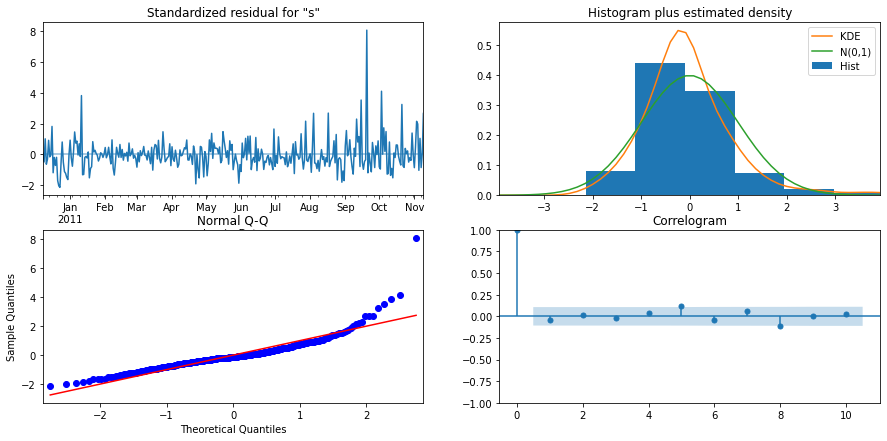

In [267]:
model.plot_diagnostics()
plt.show()

<AxesSubplot:xlabel='InvoiceDate'>

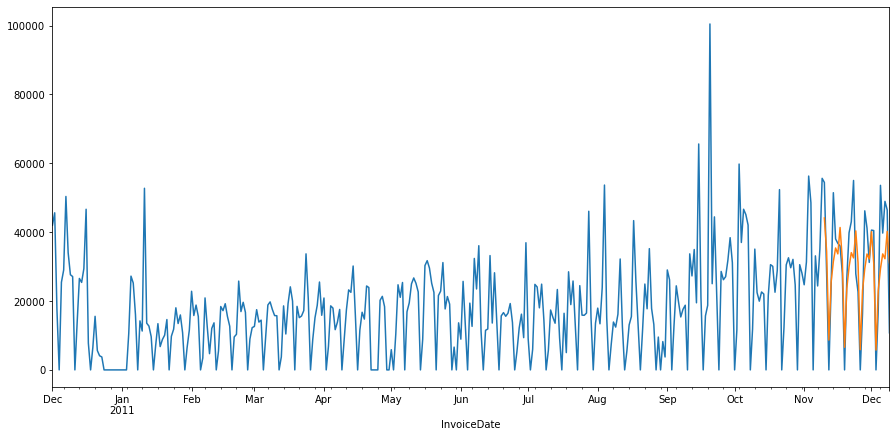

In [334]:
ts_df.sale_amount.plot()
pred.plot()

### 4. 파생변수 생성 후 시계열 분석 후 사후 분석

### 5. 3번과 4번 중 어떤 것이 예측을 잘 하였는가? 평가 후 잔차 시각화